# Convert Trained PyTorch Model to ONNX

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.onnx
import onnx

from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks, make_circle_masks_position_controlled

ModuleNotFoundError: No module named 'imageio'

In [10]:
def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    print(im.shape)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    return emoji

def load_mons_image(path):
    im = imageio.imread(path)
    emoji = np.array(im.astype(np.float32))
    emoji /= 255.0
    return emoji

In [11]:
class CAModel_onnx(nn.Module):
    def __init__(self, channel_n, fire_rate, device, hidden_size=128):
        super(CAModel_onnx, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fc0 = nn.Linear(channel_n*3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        with torch.no_grad():
            self.fc1.weight.zero_()

        self.fire_rate = fire_rate
        self.to(self.device)

    def alive(self, x):
        return F.max_pool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1
        # return onnx.MaxUnpool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(np.asarray(weight).astype(np.float32)).to(self.device)
            # conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1,1,3,3).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle*np.pi/180)
        s = np.sin(angle*np.pi/180)
        w1 = c*dx-s*dy
        w2 = s*dx+c*dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x,y1,y2),1)
        return y

    def update(self, x, fire_rate, angle):
        x = x.transpose(1,3)
        pre_life_mask = self.alive(x)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        x = x+dx.transpose(1,3)

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        return x.transpose(1,3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0):
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
        return x

In [12]:
device: str = torch.device("cpu")
model_path: str = "models/remaster_1.pth"
save_model_path: str = "models/test_001.pth"

CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
n_epoch = 80000

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI_PATH = "data/emoji.png"
TARGET_EMOJI = 0 #@param "🦎"

EXPERIMENT_TYPE = "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

model = CAModel_onnx(CHANNEL_N, CELL_FIRE_RATE, "cpu").to("cpu")
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

## Show target emoji

(40, 400, 4)


/var/folders/tm/86wgj2997xndj59gns7sx12m0000gn/T/ipykernel_55247/3690617137.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)


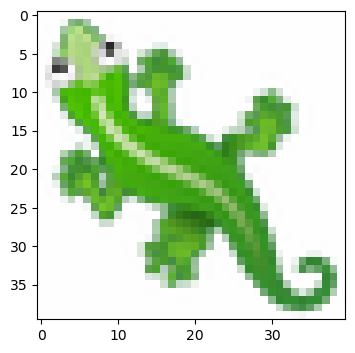

In [15]:
target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.show()

In [ ]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = make_seed((h, w), CHANNEL_N)[None, ...]
dummy_input = torch.from_numpy(seed.astype(np.float32)).to("cpu")

model.eval()

torch.onnx.export(model,         # model being run 
    dummy_input,       # model input (or a tuple for multiple inputs) 
    "./models/GrowingNeuralCellularAutomata.onnx",       # where to save the model  
    export_params=True,  # store the trained parameter weights inside the model file 
    opset_version=10,    # the ONNX version to export the model to 
    do_constant_folding=True,  # whether to execute constant folding for optimization 
    input_names = ['modelInput'],   # the model's input names 
    output_names = ['modelOutput'], # the model's output names 
    dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                        'modelOutput' : {0 : 'batch_size'}}) 

In [ ]:
# 1x1x28x28 のダミーデータを用意する
#dummy_input = torch.randn(1, 1, 28, 28, device=device)

target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.show()

p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
dummy_input = torch.from_numpy(pad_target.astype(np.float32)).to(device)

# 学習済みモデルとダミーデータを用いてONNX形式のモデルをファイルに出力
torch.onnx.export(ca, dummy_input, 'gnca.onnx')